In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

In [10]:
'''
Artificial Neural Network Class
'''
class ANN:
    import numpy as np # linear algebra
    np.random.seed(10)

    '''
    Initialize the ANN;
    HiddenLayer vector : will contain the Layers' info
    w, b, phi = (empty) arrays that will contain all the w, b and activation functions for all the Layers
    mu = cost function
    eta = a standard learning rate initialization. It can be modified by the 'set_learning_rate' method
    '''
    def __init__(self) :
        self.HiddenLayer = []
        self.w = []
        self.b = []
        self.phi = []
        self.mu = []
        self.eta = 1 #set up the proper Learning Rate!!

    '''
    add method: to add layers to the network
    '''
    def add(self, lay = (4, 'ReLU') ):
        self.HiddenLayer.append(lay)

    '''
    FeedForward method: as explained before.
    '''
    @staticmethod
    def FeedForward(w, b, phi, x):
        return phi(np.dot(w, x) + b)

    '''
    BackPropagation algorithm implementing the Gradient Descent
    '''
    def BackPropagation(self, x, z, Y, w, b, phi):
        self.delta = []

        # We initialize ausiliar w and b that are used only inside the backpropagation algorithm once called
        self.W = []
        self.B = []

        # We start computing the LAST error, the one for the OutPut Layer
        self.delta.append(  (z[len(z)-1] - Y) * phi[len(z)-1](z[len(z)-1], der=True) )

        '''Now we BACKpropagate'''
        # We thus compute from next-to-last to first
        for i in range(0, len(z)-1):
            self.delta.append( np.dot( self.delta[i], w[len(z)- 1 - i] ) * phi[len(z)- 2 - i](z[len(z)- 2 - i], der=True) )

        # We have the error array ordered from last to first; we flip it to order it from first to last
        self.delta = np.flip(self.delta, 0)

        # Now we define the delta as the error divided by the number of training samples
        self.delta = self.delta/self.X.shape[0]

        '''GRADIENT DESCENT'''
        # We start from the first layer that is special, since it is connected to the Input Layer
        self.W.append( w[0] - self.eta * np.kron(self.delta[0], x).reshape( len(z[0]), x.shape[0] ) )
        self.B.append( b[0] - self.eta * self.delta[0] )

        # We now descend for all the other Hidden Layers + OutPut Layer
        for i in range(1, len(z)):
            self.W.append( w[i] - self.eta * np.kron(self.delta[i], z[i-1]).reshape(len(z[i]), len(z[i-1])) )
            self.B.append( b[i] - self.eta * self.delta[i] )

        # We return the descended parameters w, b
        return np.array(self.W), np.array(self.B)


    '''
    Fit method: it calls FeedForward and Backpropagation methods
    '''
    def Fit(self, X_train, Y_train):
        print('Start fitting...')
        '''
        Input layer
        '''
        self.X = X_train
        self.Y = Y_train

        '''
        We now initialize the Network by retrieving the Hidden Layers and concatenating them
        '''
        print('Model recap: \n')
        print('You are fitting an ANN with the following amount of layers: ', len(self.HiddenLayer))

        for i in range(0, len(self.HiddenLayer)) :
            print('Layer ', i+1)
            print('Number of neurons: ', self.HiddenLayer[i][0])
            if i==0:
                # We now try to use the He et al. Initialization from ArXiv:1502.01852
                self.w.append( np.random.randn(self.HiddenLayer[i][0] , self.X.shape[1])/np.sqrt(2/self.X.shape[1]) )
                self.b.append( np.random.randn(self.HiddenLayer[i][0])/np.sqrt(2/self.X.shape[1]))
                # Old initialization
                #self.w.append(2 * np.random.rand(self.HiddenLayer[i][0] , self.X.shape[1]) - 0.5)
                #self.b.append(np.random.rand(self.HiddenLayer[i][0]))

                # Initialize the Activation function
                for act in Activation_function.list_act():
                    if self.HiddenLayer[i][1] == act :
                        self.phi.append(Activation_function.get_act(act))
                        print('\tActivation: ', act)

            else :
                # We now try to use the He et al. Initialization from ArXiv:1502.01852
                self.w.append( np.random.randn(self.HiddenLayer[i][0] , self.HiddenLayer[i-1][0] )/np.sqrt(2/self.HiddenLayer[i-1][0]))
                self.b.append( np.random.randn(self.HiddenLayer[i][0])/np.sqrt(2/self.HiddenLayer[i-1][0]))
                # Old initialization
                #self.w.append(2*np.random.rand(self.HiddenLayer[i][0] , self.HiddenLayer[i-1][0] ) - 0.5)
                #self.b.append(np.random.rand(self.HiddenLayer[i][0]))

                # Initialize the Activation function
                for act in Activation_function.list_act():
                    if self.HiddenLayer[i][1] == act :
                        self.phi.append(Activation_function.get_act(act))
                        print('\tActivation: ', act)

        '''
        Now we start the Loop over the training dataset
        '''
        for I in range(0, self.X.shape[0]): # loop over the training set
            '''
            Now we start the feed forward
            '''
            self.z = []

            self.z.append( self.FeedForward(self.w[0], self.b[0], self.phi[0], self.X[I]) ) # First layers

            for i in range(1, len(self.HiddenLayer)): #Looping over layers
                self.z.append( self.FeedForward(self.w[i] , self.b[i], self.phi[i], self.z[i-1] ) )


            '''
            Here we backpropagate
            '''
            self.w, self.b  = self.BackPropagation(self.X[I], self.z, self.Y[I], self.w, self.b, self.phi)

            '''
            Compute cost function
            '''
            self.mu.append(
                (1/2) * np.dot(self.z[len(self.z)-1] - self.Y[I], self.z[len(self.z)-1] - self.Y[I])
            )

        print('Fit done. \n')



    '''
    predict method
    '''
    def predict(self, X_test):

        print('Starting predictions...')

        self.pred = []
        self.XX = X_test

        for I in range(0, self.XX.shape[0]): # loop over the training set

            '''
            Now we start the feed forward
            '''
            self.z = []

            self.z.append(self.FeedForward(self.w[0] , self.b[0], self.phi[0], self.XX[I])) #First layer

            for i in range(1, len(self.HiddenLayer)) : # loop over the layers
                self.z.append( self.FeedForward(self.w[i] , self.b[i], self.phi[i], self.z[i-1]))

            # Append the prediction;
            # We now need a binary classifier; we this apply an Heaviside Theta and we set to 0.5 the threshold
            # if y < 0.5 the output is zero, otherwise is zero
            self.pred.append( np.heaviside(  self.z[-1] - 0.5, 1)[0] ) # NB: self.z[-1]  is the last element of the self.z list

        print('Predictions done. \n')

        return np.array(self.pred)

    '''
    We need a method to retrieve the accuracy for each training data to follow the learning of the ANN
    '''
    def get_accuracy(self):
        return np.array(self.mu)
    # This is the averaged version
    def get_avg_accuracy(self):
        import math
        self.batch_loss = []
        for i in range(0, 10):
            self.loss_avg = 0
            # To set the batch in 10 element/batch we use math.ceil method
            # int(math.ceil((self.X.shape[0]-10) / 10.0))    - 1
            for m in range(0, (int(math.ceil((self.X.shape[0]-10) / 10.0))   )-1):
                #self.loss_avg += self.mu[60*i+m]/60
                self.loss_avg += self.mu[(int(math.ceil((self.X.shape[0]-10) / 10.0)) )*i + m]/(int(math.ceil((self.X.shape[0]-10) / 10.0)) )
            self.batch_loss.append(self.loss_avg)
        return np.array(self.batch_loss)

    '''
    Method to set the learning rate
    '''
    def set_learning_rate(self, et=1):
        self.eta = et


'''
layers class
'''
class layers :
    '''
    Layer method: used to call standar layers to add.
    Easily generalizable to more general layers (Pooling and Convolutional layers)
    '''
    def layer(p=4, activation = 'ReLU'):
        return (p, activation)

'''
Activation functions class
'''
class Activation_function(ANN):
    import numpy as np

    def __init__(self) :
        super().__init__()

    '''
    Define the sigmoid activator; we ask if we want the sigmoid or its derivative
    '''
    def sigmoid_act(x, der=False):
        if (der==True) : #derivative of the sigmoid
            f = 1/(1+ np.exp(- x))*(1-1/(1+ np.exp(- x)))
        else : # sigmoid
            f = 1/(1+ np.exp(- x))
        return f

    '''
    Define the Rectifier Linear Unit (ReLU)
    '''
    def ReLU_act(x, der=False):
        if (der == True): # the derivative of the ReLU is the Heaviside Theta
            f = np.heaviside(x, 1)
        else :
            f = np.maximum(x, 0)
        return f

    def list_act():
        return ['sigmoid', 'ReLU']

    def get_act(string = 'ReLU'):
        if string == 'ReLU':
            return Activation_function.ReLU_act
        elif string == 'sigmoid':
            return Activation_function.sigmoid_act
        else :
            return Activation_function.sigmoid_act

In [11]:
df = pd.read_csv(r"D:\Dataset\dynamic_api_call_sequence_per_malware_100_0_306.csv")

In [12]:
features = df[df.columns[1:-1]].to_numpy()
labels = df[df.columns[-1]].to_numpy()

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

Training records: 30713
Test records: 13163


In [14]:
def get_accuracy(cm):
  true_positive = cm[1][1]
  false_positive = cm[0][1]
  false_negative = cm[1][0]
  true_negative = cm[0][0]
  return (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

In [15]:
dict_live = {
    0 : 'Benign',
    1 : 'Malware'
}

model = ANN()

model.add(layers.layer(50, 'ReLU'))
model.add(layers.layer(100, 'ReLU'))
model.add(layers.layer(1, 'sigmoid'))

model.set_learning_rate(0.05)

model.Fit(X_train, Y_train)
acc_val = model.get_accuracy()
acc_avg_val = model.get_avg_accuracy()

predictions = model.predict(X_test)

cm = confusion_matrix(Y_test, predictions)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("Classification Report:")
print(classification_report(Y_test, predictions))

# Heatmap
df_cm = pd.DataFrame(cm, index=[dict_live[i] for i in range(0, 2)], columns=[dict_live[i] for i in range(0, 2)])
plt.figure(figsize=(8, 8))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g', annot_kws={"size": 16})
plt.xlabel("Predicted Class", fontsize=18)
plt.ylabel("True Class", fontsize=18)
plt.show()

# Accuracy
accuracy = accuracy_score(Y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")
print(f"Accuracy: {get_accuracy(cm)}")

Start fitting...
Model recap: 

You are fitting an ANN with the following amount of layers:  3
Layer  1
Number of neurons:  50
	Activation:  ReLU
Layer  2
Number of neurons:  100
	Activation:  ReLU
Layer  3
Number of neurons:  1
	Activation:  sigmoid


C:\Users\user\AppData\Local\Temp\ipykernel_19916\3797313825.py:237: RuntimeWarning: overflow encountered in exp
  f = 1/(1+ np.exp(- x))


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

Accuracy: 0.9780519064402435


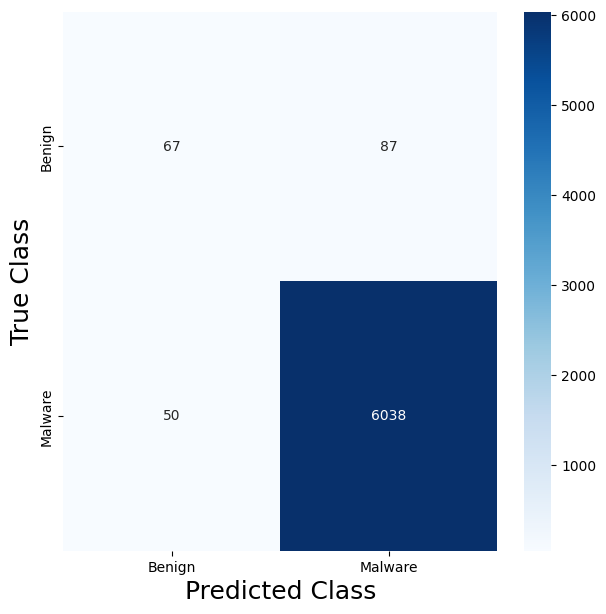

In [ ]:
# Trying with sklearn now

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100, 100), random_state=2, learning_rate_init=0.05, max_iter=1000)
clf.fit(X_train, Y_train)

predictions = clf.predict(X_test)
cm = confusion_matrix(Y_test, predictions)

print(f"Accuracy: {get_accuracy(cm)}")

df_cm = pd.DataFrame(cm, index = [dict_live[i] for i in range(0,2)], columns = [dict_live[i] for i in range(0,2)])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Class", fontsize=18)
plt.ylabel("True Class", fontsize=18)
plt.show()